# Mnist Fault injection

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import error_inject_layer
import dense_error_injection
import error_inject_optimizer
from tensorflow.python.util import deprecation
print(tf.__version__)

2.5.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load Data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Preprocess Data

In [5]:
# Scale values
train_images = train_images / 255.0
test_images = test_images / 255.0

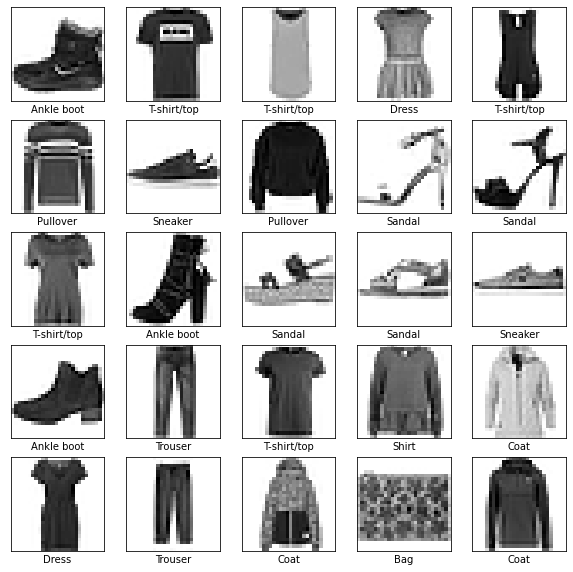

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Simple Error Free Model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
train_history = model.fit(train_images, train_labels, epochs=100, verbose=0, validation_data=(test_images,  test_labels))

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.7430 - accuracy: 0.8818

Test accuracy: 0.8817999958992004


In [11]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [12]:
predictions = probability_model.predict(test_images)

### Model with 0.1 error rate in hidden layer

In [12]:
error_model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(28, 28)),
              dense_error_injection.Dense_Error_Injection(128, activation=tf.nn.relu,
                                                          error_rate=0.1, 
                                                          error_type='random_bit_flip_percentage',
                                                          error_inject_phase='training',
                                                          error_element='weight',
                                                          verbose=0,
                                                          error_persistence=False
                                                          ),
              tf.keras.layers.Dense(10)
])

In [13]:
error_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [14]:
error_train_history = error_model.fit(train_images, train_labels, epochs=100, verbose=0, validation_data=(test_images,  test_labels))

In [15]:
test_loss, test_acc = error_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.5580 - accuracy: 0.7922

Test accuracy: 0.7922000288963318


### Compare training and accuracy of error model vs error free model

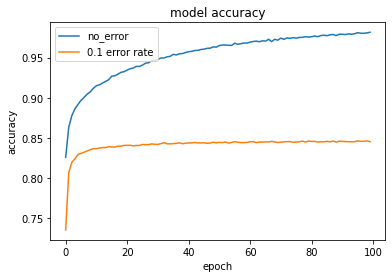

In [19]:
plt.plot(train_history.history['accuracy'])
plt.plot(error_train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no_error', '0.1 error rate'], loc='upper left')
plt.show()

### Testing multiple error rates during training

In [16]:
error_rates = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5]

# error_rates = [0.0, 0.0001, 0.001, 0.01,
#                0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
error_rate_train_history = []


In [ ]:
for error_rate in error_rates:
    test_model = tf.keras.Sequential([
                 tf.keras.layers.Flatten(input_shape=(28, 28)),
                 tf.keras.layers.Dense(512),
                 dense_error_injection.Dense_Error_Injection(512, activation=tf.nn.relu,
                                                             error_rate=error_rate, 
                                                             error_type='random_bit_flip_percentage',
                                                             error_inject_phase='training',
                                                             error_element='weight',
                                                             verbose=0,
                                                             error_persistence=False
                                                             ),
              tf.keras.layers.Dense(10)
    ])
    
    test_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    num_epochs = 300
    
    train_history_tmp = test_model.fit(x=train_images, y=train_labels, epochs=num_epochs,
                                       validation_data=(test_images,  test_labels),
                                       batch_size=32, verbose=0)
    
    error_rate_train_history.append((error_rate, train_history_tmp))


inserting 26 errors
inserting 26 errors
inserting 262 errors
inserting 262 errors
inserting 2621 errors
inserting 2621 errors
inserting 26214 errors
inserting 26214 errors


In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1].history['accuracy'])
plt.plot(error_rate_train_history[1][1].history['accuracy'])
plt.plot(error_rate_train_history[2][1].history['accuracy'])
plt.plot(error_rate_train_history[3][1].history['accuracy'])
plt.plot(error_rate_train_history[4][1].history['accuracy'])
plt.plot(error_rate_train_history[5][1].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([
            f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate',
            f'{error_rate_train_history[2][0]} error rate',
            f'{error_rate_train_history[3][0]} error rate',
            f'{error_rate_train_history[4][0]} error rate',
            f'{error_rate_train_history[5][0]} error rate'
            ])
plt.figure(figsize=(3, 3))
plt.show()

In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1].history['loss'])
plt.plot(error_rate_train_history[1][1].history['loss'])
plt.plot(error_rate_train_history[2][1].history['loss'])
plt.plot(error_rate_train_history[3][1].history['loss'])
# plt.plot(error_rate_train_history[6][1].history['loss'])
# plt.plot(error_rate_train_history[10][1].history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([
            f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate',
            f'{error_rate_train_history[2][0]} error rate',
            f'{error_rate_train_history[3][0]} error rate'
#             f'{error_rate_train_history[6][0]} error rate',
#             f'{error_rate_train_history[10][0]} error rate'
          ])
plt.show()

In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1].history['accuracy'])
plt.plot(error_rate_train_history[1][1].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([
            f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate'])
plt.show()

# FAULT EFFECT ON INFERENCE

In [12]:
error_rate = 0.00

In [13]:
fault_free_model = tf.keras.Sequential([
                   tf.keras.layers.Flatten(input_shape=(28, 28)),
                   error_inject_layer.DenseErrorLayer(128, activation=tf.nn.relu,
                                                      error_rate=error_rate, 
                                                      error_type='random_bit_flip_percentage',
                                                      error_inject_phase='inference',
                                                      error_element='weight',
                                                      verbose=0,
                                                      error_persistence=False
                                                     ),
                   tf.keras.layers.Dense(10)
])

In [14]:
fault_free_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
train_history = fault_free_model.fit(train_images, train_labels, epochs=100, verbose=0, validation_data=(test_images,  test_labels))

#### Accuracy and loss with no injected errors

In [11]:
test_loss, test_acc = fault_free_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.8531 - accuracy: 0.8809

Test accuracy: 0.8809000253677368


In [12]:
probability_model = tf.keras.Sequential([fault_free_model, 
                                         tf.keras.layers.Softmax()])

In [34]:
predictions = probability_model.predict(test_images)

In [35]:
predictions.shape

(10000, 10)

In [36]:
tf.argmax(predictions, axis=1)

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([9, 2, 1, ..., 8, 1, 5])>

In [37]:
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state(test_labels, predictions)
print(f"Loss (SparseCategoricalCrossentropy): {m.result().numpy()}")

Loss (SparseCategoricalCrossentropy): 0.734483003616333


In [39]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_labels, tf.argmax(predictions, axis=1))
print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.8809000253677368


In [19]:
#fault_free_model.save_weights('./saved_models/fault_free_weights')

### Inference Accuracy with 0.1 (10%) error rate

In [20]:
test_labels.shape

(10000,)

In [23]:
individual_predictions = np.zeros((10000,10))
individual_predictions.shape

(10000, 10)

In [26]:
probability_model.layers[0].layers[1].error_rate = 0.1
for count in range(0,individual_predictions.shape[0]):
    image = test_images[count]
    temp = probability_model.__call__((np.expand_dims(image,0)))
    individual_predictions[count] = temp

In [28]:
individual_predictions

array([[1.42187120e-24, 1.23703658e-38, 9.73206837e-27, ...,
        1.70996842e-10, 4.28537355e-30, 1.00000000e+00],
       [2.42059706e-11, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 2.17960185e-34, 5.29377395e-36],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.31388341e-21, 1.07524456e-37, 2.65736590e-18, ...,
        7.92309510e-38, 1.00000000e+00, 5.90006651e-37],
       [0.00000000e+00, 1.00000000e+00, 4.96909124e-38, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.58706439e-10, 3.69907405e-25, 2.75467920e-19, ...,
        1.38176538e-05, 6.00519426e-11, 1.24497614e-17]])

In [32]:
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state(test_labels, individual_predictions)
m.result().numpy()

3.3900914

In [42]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_labels, tf.argmax(individual_predictions, axis=1))
print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.7268999814987183


### Inference with 0.9 (90%) error rate

In [46]:
error_rate = 0.9
fault_free_model_tmp = tf.keras.Sequential([
                       tf.keras.layers.Flatten(input_shape=(28, 28)),
                       error_inject_layer.DenseErrorLayer(128, activation=tf.nn.relu,
                                                      error_rate=error_rate, 
                                                      error_type='random_bit_flip_percentage',
                                                      error_inject_phase='inference',
                                                      error_element='weight',
                                                      verbose=0,
                                                      error_persistence=False
                                                     ),
                       tf.keras.layers.Dense(10)
])

# Restore the weights
fault_free_model_tmp.load_weights('./saved_models/fault_free_weights')

In [47]:
fault_free_model_tmp.layers[1].error_rate

0.9

In [48]:
probability_model_tmp = tf.keras.Sequential([fault_free_model_tmp, 
                                            tf.keras.layers.Softmax()])

In [49]:
predictions_tmp = probability_model_tmp.predict(test_images, batch_size=32)

In [50]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_labels, tf.argmax(predictions_tmp, axis=1))
print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.38449999690055847


In [7]:
error_rates = np.geomspace(0.0001, 1, num=100)

In [10]:
error_rates[90:]

array([0.39442061, 0.43287613, 0.47508102, 0.52140083, 0.57223677,
       0.62802914, 0.68926121, 0.75646333, 0.83021757, 0.91116276,
       1.        ])

In [18]:
accuracy_vs_error_rate = []
for er in error_rates:
    ER = float(er)
    fault_free_model.layers[1].error_rate = 0.0
    fault_free_model.load_weights('./saved_models/fault_free_weights')
    
    fault_free_model.layers[1].error_rate = ER

    probability_model_tmp = tf.keras.Sequential([fault_free_model, 
                                                tf.keras.layers.Softmax()])
    output_array = np.empty((10000,10))
    for image_num in range(0,10000):
        image = test_images[image_num]
        output_array[image_num] = probability_model_tmp.__call__((np.expand_dims(image,0)))
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(test_labels, tf.argmax(output_array, axis=1))
    print(f"Accuracy for ER {ER}: {m.result().numpy()}")
    accuracy_vs_error_rate.append((ER,m.result().numpy()))
    
# np.save('results/accuracy_vs_error_rate.npy', accuracy_vs_error_rate)

In [20]:
accuracy_vs_error_rate = np.load('results/accuracy_vs_error_rate.npy')

In [38]:
print(accuracy_vs_error_rate[:5,:])
print('...')
print(accuracy_vs_error_rate[95:,:])

[[1.00000000e-04 8.80599976e-01]
 [1.09749877e-04 8.80800009e-01]
 [1.20450354e-04 8.80699992e-01]
 [1.32194115e-04 8.80900025e-01]
 [1.45082878e-04 8.80900025e-01]]
...
[[0.68926121 0.35519999]
 [0.75646333 0.3364    ]
 [0.83021757 0.31959999]
 [0.91116276 0.29769999]
 [1.         0.28369999]]


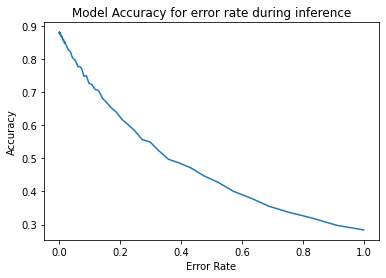

In [31]:
plt.plot(accuracy_vs_error_rate[:,0], accuracy_vs_error_rate[:,1])
plt.title('Model Accuracy for error rate during inference')
plt.ylabel('Accuracy')
plt.xlabel('Error Rate')
# plt.legend(['no_error', '0.1 error rate'], loc='upper left')
plt.show()

In [74]:
accuracy_array = []
for er in error_rates:
    ER = float(er)
    fault_free_model.layers[1].error_rate = 0.0
    fault_free_model.load_weights('./saved_models/fault_free_weights')
    
    fault_free_model.layers[1].error_rate = ER

    probability_model_tmp = tf.keras.Sequential([fault_free_model, 
                                                tf.keras.layers.Softmax()])
    
    predictions_tmp = probability_model_tmp.predict(test_images, batch_size=32)
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(test_labels, tf.argmax(predictions_tmp, axis=1))
    print(f"Accuracy for ER {ER}: {m.result().numpy()}")
    accuracy_array.append((ER,m.result().numpy()))

Accuracy for ER 0.0001: 0.8809000253677368
Accuracy for ER 0.00010974987654930556: 0.8806999921798706
Accuracy for ER 0.00012045035402587823: 0.8810999989509583
Accuracy for ER 0.00013219411484660288: 0.8808000087738037
Accuracy for ER 0.000145082877849594: 0.8808000087738037
Accuracy for ER 0.00015922827933410923: 0.8809999823570251
Accuracy for ER 0.0001747528400007683: 0.8808000087738037
Accuracy for ER 0.00019179102616724886: 0.8809000253677368
Accuracy for ER 0.00021049041445120198: 0.8812000155448914
Accuracy for ER 0.00023101297000831605: 0.8809999823570251
Accuracy for ER 0.00025353644939701115: 0.8815000057220459
Accuracy for ER 0.0002782559402207126: 0.8805999755859375
Accuracy for ER 0.0003053855508833416: 0.8809999823570251
Accuracy for ER 0.0003351602650938841: 0.8802000284194946
Accuracy for ER 0.0003678379771828634: 0.8809999823570251
Accuracy for ER 0.0004037017258596554: 0.879800021648407
Accuracy for ER 0.0004430621457583882: 0.8799999952316284
Accuracy for ER 0.00048

In [98]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_labels[0], output_array[0])
m.result().numpy()

ValueError: Shapes (1, 10) and () are incompatible

In [ ]:
fault_free_model.layers[1].error_rate

In [ ]:
test_loss, test_acc = fault_free_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
predictions = probability_model.predict(test_images)

In [ ]:
predictions